In [184]:
%matplotlib inline  
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import tempfile
import imutils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [185]:
def set_image_dpi(file_path):
    """
    Return opencv2 image from file_path with a DPI of 300. Optimized for pytesseract.
    """
    if isinstance(file_path, str):
        im = Image.open(file_path)
    else:
        im = image
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return cv2.imread(temp_filename)

In [219]:
img_name = "test_imgs/img01.jpg"

In [220]:
image = set_image_dpi(img_name)

In [221]:
"""Trying to find a bounding box for the receipts, to cut out noise. Not that successful at the moment."""
def cut_receipt_out(image, blocksize=10, ksize=50):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, blocksize, ksize)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    draw_contours(image, cnts)
    return edged

def draw_contours(image, cnts):
    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            cv2.imwrite('cropped_' + str(i) + '_img.jpg', image)
            break
    if screenCnt is not None:
        print("Drawing Contours")
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

Drawing Contours


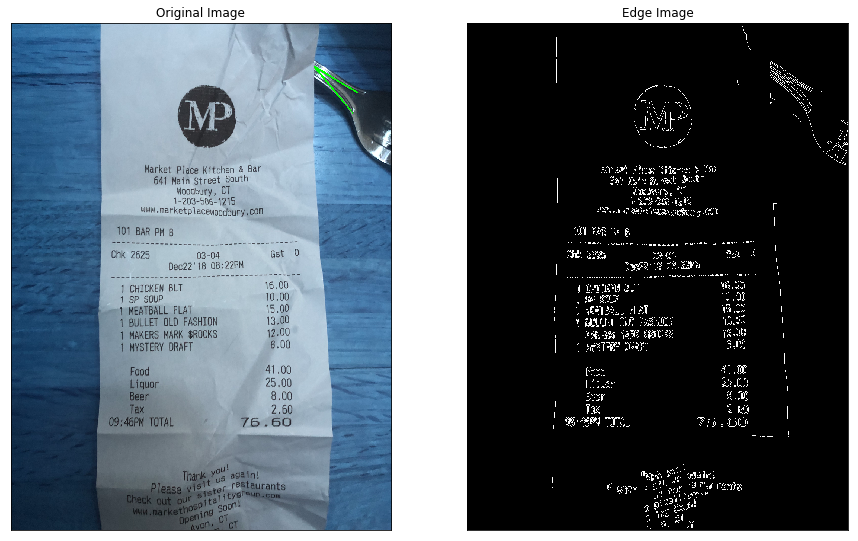

In [222]:
edge1 = cut_receipt_out(image, 100, 200)

plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edge1, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [223]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

mb = cv2.medianBlur(gray, 3)
bf = cv2.bilateralFilter(gray, 9, 10, 200)
th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
at_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
at_gaussian = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

In [224]:
titles = ['Original Image',
          'Gray',
          'Median Blur',
          'Bilateral Filter'
          'Threshold',
          'Adaptive Mean Thresholding',
          'Adaptive Gaussian Thresholding']


images = [image, gray,mb, bf, th, at_gaussian, at_mean]

In [225]:
def run(titles, images, print_text=True):
    every_other = False
    plt.rcParams['figure.figsize'] = [15, 10]
    for i in range(len(titles)):
        if print_text:
            # print(titles[i])
            filename = "{}.png".format(os.getpid())
            cv2.imwrite(filename, images[i])
            text = pytesseract.image_to_string(Image.open(filename))
            os.remove(filename)
        if every_other:
            ax2 = plt.subplot(122)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            text2 = text

            plt.annotate(text2, (0,0), (0, -20), xycoords='axes fraction',
                         textcoords='offset points', va='top', transform=ax2.transAxes)
            plt.title(titles[i]), plt.xticks([]), plt.yticks([])
            plt.show()
            every_other = False
        else:
            ax1 = plt.subplot(121)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            text1 = text
            plt.annotate(text1, (0,0), (0, -20), xycoords='axes fraction',
                         textcoords='offset points', va='top', transform=ax1.transAxes)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            plt.title(titles[i]), plt.xticks([]), plt.yticks([])
            every_other = True
    # For odd number of graphs
    if every_other:
        plt.text(text1, (0,0), (0, -20), transform=ax1.transAxes)
        plt.show()

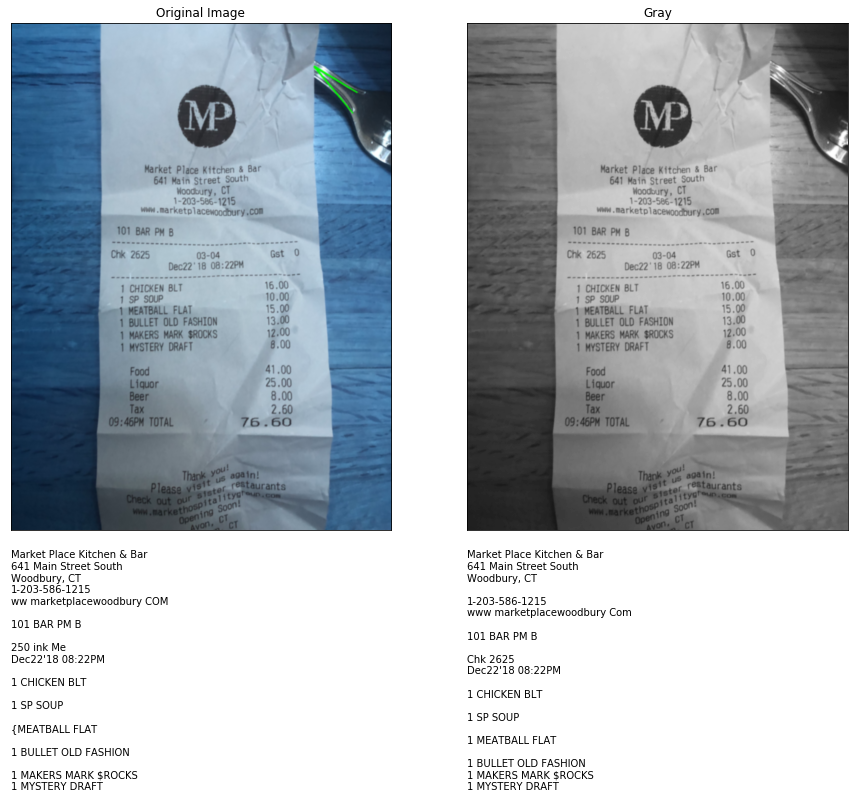

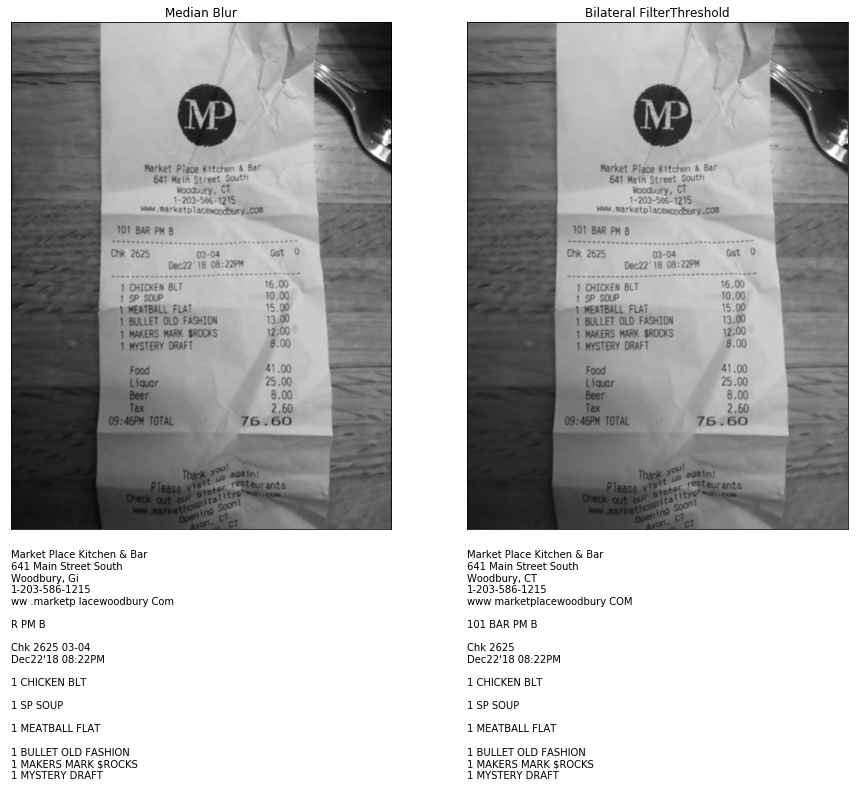

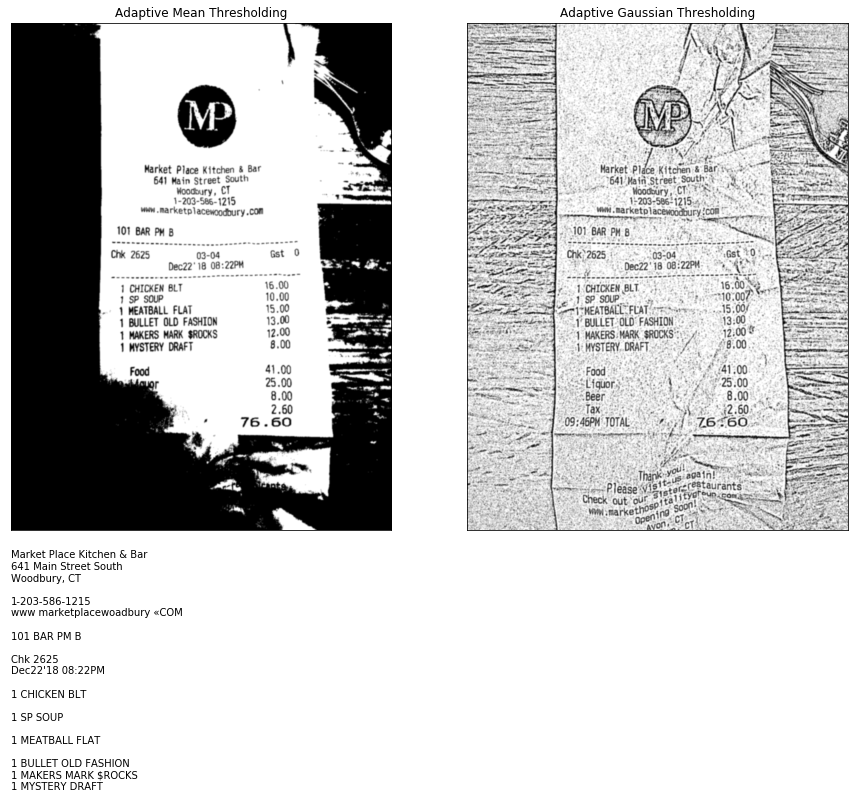

In [226]:
run(titles, images)